# Deep Recurrent Q-Learning

### Resources

- https://arxiv.org/pdf/1507.06527

In [14]:

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import time
import torch
import torch.nn as nn
import gymnasium as gym
import ale_py
import matplotlib.pyplot as plt

from collections import deque
from gymnasium.wrappers import FrameStack
from gymnasium.wrappers.frame_stack import LazyFrames
from stable_baselines3.common.atari_wrappers import (
    AtariWrapper,
    FireResetEnv,
)

gym.register_envs(ale_py)

from utils.replay import ReplayBuffer, make_env, LazyFramesToNumpyWrapper

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [11]:
def display_frame(frame, gray=False):
    if gray:
        plt.imshow(frame, cmap='gray')
    else:
        plt.imshow(frame)
    plt.axis('off')
    plt.show()

In [15]:
def make_env(game, render='rgb_array'):
    env = gym.make(game, render_mode=render)
    env = AtariWrapper(env, terminal_on_life_loss=False)
    env = LazyFramesToNumpyWrapper(env)
    if "FIRE" in env.unwrapped.get_action_meanings():
        env = FireResetEnv(env)
    return env

In [16]:
env_test = make_env('PongNoFrameskip-v4')

(84, 84, 1)


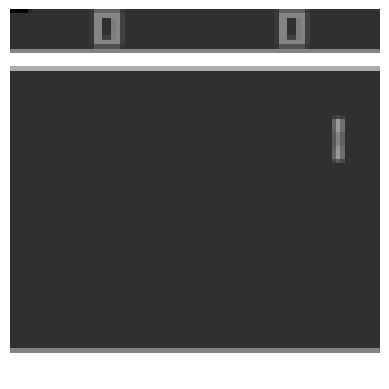

In [19]:
observation, _ = env_test.reset()
print(observation.shape)
display_frame(observation, gray=True)

In [5]:
class DRQN(nn.Module):
    
    def __init__(
        self, 
        env,
        in_channels=1, 
        hidden_filters=list([32, 64, 64]),
        hidden_size=512,
        start_epsilon = 0.99,
        max_decay = 0.1,
        decay_steps = 1000, 
        device='cuda', 
        *args, 
        **kwargs
    ):
        super().__init__(*args, **kwargs)
        self.env = env
        self.start_epsilon = start_epsilon
        self.epsilon = start_epsilon
        self.max_decay = max_decay
        self.decay_steps = decay_steps
        self.num_actions = env.action_space.n
        
        self.layers_cnn = nn.Sequential(
            nn.Conv2d(in_channels, hidden_filters[0], kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(hidden_filters[0], hidden_filters[1], kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(hidden_filters[1], hidden_filters[2], kernel_size=3, stride=1),
            nn.ReLU(),
        )
        
        
        self.lstm = nn.LSTM(hidden_filters[-1] * 7 * 7, hidden_size)
        self.linear = nn.Linear(hidden_size, self.num_actions)
        
        self.apply(self._init)
    
    def forward(self, x, hidden_state, cell):
        x = self.layers_cnn(x / 255.0)
        x, hidden_state, cell = self.lstm(x, (hidden_state, cell))
        
        return ...
        
    def _init(self, m):
      if isinstance(m, (nn.Linear, nn.Conv2d)):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
          nn.init.zeros_(m.bias)
              
    def epsilon_greedy(self, state, dim=1):
        rng = np.random.random()

        if rng < self.epsilon:
            action = self.env.action_space.sample()
            action = torch.tensor(action)
        else:
            with torch.no_grad():
                q_values = self(state)
            
            action = torch.argmax(q_values, dim=dim)

        return action

    def epsilon_decay(self, step):
        self.epsilon = self.max_decay + (self.start_epsilon - self.max_decay) * max(0, (self.decay_steps - step) / self.decay_steps)
        
